<a href="https://colab.research.google.com/github/nikhildr22/Speech-Emotion-Recognition/blob/master/single_audio_mfcc_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
''' Using Tensorflow 1.x '''

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
''' listing directories '''
!ls

sample_data


In [3]:
''' Downloading the dataset from the website in zip compressed format '''
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2020-05-01 05:09:59--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  10.4MB/s    in 24s     

2020-05-01 05:10:25 (8.23 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [4]:
''' creating a folder - 'dataset' to keep the data '''
!mkdir dataset
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [0]:
''' unzipping the dataset into the destination folder 'dataset' '''
!unzip -q Audio_Speech_Actors_01-24.zip -d dataset

In [6]:
''' listing directories '''
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [7]:
''' Installing soundfile module via pip '''
!pip install soundfile

In [0]:
''' importing required modules '''
import librosa
from tqdm import tqdm
import soundfile
from scipy.io import wavfile
import os, glob, pickle
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt

In [86]:
''' creating a directory to keep clean files '''
!mkdir clean 

mkdir: cannot create directory ‘clean’: File exists


In [87]:
''' downsampling audio files to 16KHz and storing them in /clean directory ''' 
for f in tqdm(glob.glob("dataset/*/*")):
    signal, rate = librosa.load(path=f, sr=16000)
    wavfile.write(filename='clean/'+f[-24:],rate=rate,data=signal)

  4%|▎         | 51/1440 [00:14<06:33,  3.53it/s]

KeyboardInterrupt: ignored

In [88]:
file = 'clean/03-01-01-01-02-02-02.wav'
with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            print("signal length= " ,len(signal))
            print("sample rate = ",sample_rate)

signal length=  57658
sample rate =  16000


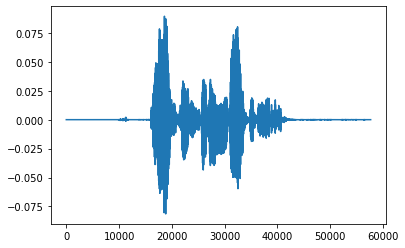

In [89]:
plt.plot(signal)
plt.show()

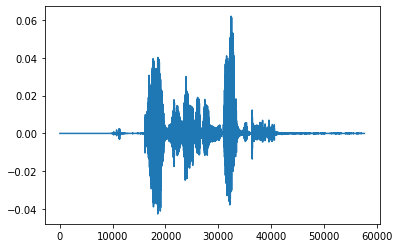

In [90]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plt.plot(emphasized_signal)
plt.show()

In [91]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
print("frame length = ",frame_length)
print("frame step = ",frame_step)
signal_length = len(emphasized_signal)
print("emphasized signal length = ",signal_length)
frame_length = int(round(frame_length))

frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
print("number of frames = ",num_frames)
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames,1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length,1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]
# frames = pad_signal[indices]
print(frames.shape)

frame length =  400.0
frame step =  160.0
emphasized signal length =  57658
number of frames =  358
(358, 400)


In [0]:
frames =frames * np.hamming(frame_length) #hamming window

In [0]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [94]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Converting Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt+2)
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Converting Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)
# print(hz_points,bin)
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  
filter_banks = 20 * np.log10(filter_banks)  # dB
print(filter_banks.shape)

(358, 40)


In [0]:
num_ceps = 26
mfccs = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

Text(0.5, 1.0, 'the mfcc image')

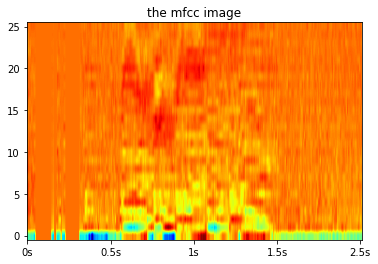

In [98]:
plt.imshow(mfccs.T, cmap=plt.cm.jet, aspect='auto')
plt.xticks(np.arange(0, (mfccs.T).shape[1],
int((mfccs.T).shape[1] / 4)),
['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
ax = plt.gca()
ax.invert_yaxis()
plt.title('the mfcc image')